<a href="https://colab.research.google.com/github/bcrompvoets/Star_Formation/blob/main/SF_Classify_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Class I, II, and others using XGBoost

Using data from the four IRAC bands (3.6, 4.5, 5.8, and 8  μm), we classify each object as "other", Class I or Class II protostars. We use a XGBoost Classifier with default values. 

This data comes from Cornu and Montillaud (2021) (https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/647/A116) and includes Spitzer data of the Orion and NGC 2264 star forming regions.

In [ ]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# classic ML libraries
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# custom made libraries
from custom_dataloader import replicate_data

: 

In [ ]:
# data load
X = np.load("Input_Class_AllClasses_Sep.npy")
# Y = np.load("Target_Class_AllClasses_Sep.npy") # For original targets via Gutermuth 2009 Method
Y = np.load("Pred_Class_AllClasses_Sep.npy") # For predicted targets from CM21


# custom data loader to pull in custom sized data set
# use seed to get replicable results for now
seed_val = 1111

# the amounts below are how many of each class of object you want in the training set and validation set - leftover amounts given to testing set

# CM21 Split
# amounts_train = [331,1141,231,529,27,70,1257]
# amounts_val = [82, 531, 104, 278, 6, 17, 4359]
# amounts_train = [331,1141,231+529+27+70+1257]
# amounts_val = [82, 531, 104+278+6+17+4359]


# 300s Split
amounts_train = [300,600,300,300,27,70,300]
amounts_val = [82, 531, 104, 278, 6, 17, 4359]
# amounts_train = [300,300,300+300+27+70+300]
# amounts_val = [82, 531, 104+278+6+17+4359]


# 75/25 Split
# amounts_train = [311,1994,391,1043,25,66,21796] #75/25 train
# amounts_val = [103,665,130,348,9,22,5449] #75/25 val

# calling custom datagrabber here
inp_tr, tar_tr, inp_va, tar_va, inp_te, tar_te = replicate_data(X, Y, 'three', amounts_train, amounts_val, seed_val)

# scaling data according to training inputs
scaler_S = StandardScaler().fit(inp_tr)
inp_tr = scaler_S.transform(inp_tr)
inp_va = scaler_S.transform(inp_va)

# COMMENT NEXT LINE IF RUNNING 75/25 SPLIT
# inp_te = scaler_S.transform(inp_te) # Comment out for 75/25 split

# printouts for double checking all the sets and amounts
print('Sizes of Datasets : Inputs , Targets')
print('------------------------------------')
print(f'Training set: {inp_tr.shape} , {tar_tr.shape} \nValidation set: {inp_va.shape} , {tar_va.shape} \nTesting Set: {inp_te.shape}, {tar_te.shape}')
print('------------------------------------')


Training set ==  (20177, 8) (20177, 1) , Validation set ==  (6726, 8) (6726, 1)


: 

In [6]:
# xgbcl = xgb.XGBClassifier()
# parameters = {'subsample':[0.5,1.0],'max_depth':np.arange(1,11,2),'sampling_method':['uniform']}

# grid = GridSearchCV(xgbcl, parameters)

xgbcl = xgb.XGBClassifier(max_depth=7,sampling_method='uniform',subsample=0.5)


In [7]:
start = time.time()

xgbcl.fit(inp_tr,tar_tr.ravel())  # fit the model with training set

end = time.time()
time_taken = (end - start)
print ('Time Taken: ',time_taken)

Time Taken:  209.135103225708


In [8]:
# Find the predicted values
pred_tr = xgbcl.predict(inp_tr)
pred_va = xgbcl.predict(inp_va)

In [12]:
f = open("PRAScores_XGB_CII600.txt", "w")

est, low, up, stderr = bootstrap_estimate_and_ci(xgbcl, inp_tr, tar_tr.ravel(),  inp_va, tar_va, scoring_func=recall_score, random_seed=0, 
                              alpha=0.05, n_splits=200)

f.write("XGB Recall\n")
f.write("{:.3f}".format(est[0])+" _{"+"{:.3f}".format(low[0])+"}^{"+"{:.3f}".format(up[0])+"} , "+"{:.3f}".format(stderr[0])+"//\n")
f.write("{:.3f}".format(est[1])+" _{"+"{:.3f}".format(low[1])+"}^{"+"{:.3f}".format(up[1])+"} , "+"{:.3f}".format(stderr[1])+"//\n")
f.write("{:.3f}".format(est[2])+" _{"+"{:.3f}".format(low[2])+"}^{"+"{:.3f}".format(up[2])+"} , "+"{:.3f}".format(stderr[2])+"//\n")
f.write("\n")

est, low, up, stderr = bootstrap_estimate_and_ci(xgbcl, inp_tr, tar_tr.ravel(), inp_va, tar_va.ravel(), scoring_func=precision_score, random_seed=0, 
                              alpha=0.05, n_splits=200)
                            
f.write("XGB Precision\n")
f.write("{:.3f}".format(est[0])+" _{"+"{:.3f}".format(low[0])+"}^{"+"{:.3f}".format(up[0])+"} , "+"{:.3f}".format(stderr[0])+"//\n")
f.write("{:.3f}".format(est[1])+" _{"+"{:.3f}".format(low[1])+"}^{"+"{:.3f}".format(up[1])+"} , "+"{:.3f}".format(stderr[1])+"//\n")
f.write("{:.3f}".format(est[2])+" _{"+"{:.3f}".format(low[2])+"}^{"+"{:.3f}".format(up[2])+"} , "+"{:.3f}".format(stderr[2])+"//\n")
f.write("\n")

est, low, up, stderr = bootstrap_estimate_and_ci(xgbcl, inp_tr, tar_tr.ravel(), inp_va, tar_va.ravel(), scoring_func=accuracy_score, random_seed=0, 
                               alpha=0.05, n_splits=200)
                            
f.write("XGB Accuracy\n")
f.write("{:.3f}".format(est)+" _{"+"{:.3f}".format(low)+"}^{"+"{:.3f}".format(up)+"} , "+"{:.3f}".format(stderr)+"//\n")
f.write("\n")
f.close()

0.9969767557119492 0.9824561403508771


# Discussion

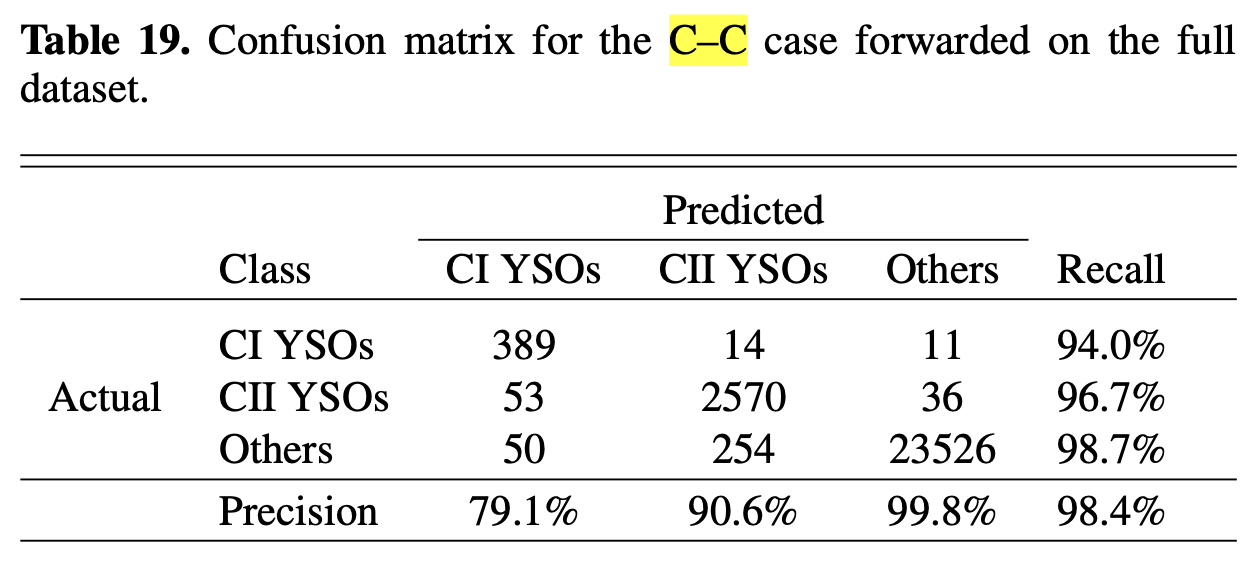

The above figure shows the results of Cornu & Montillaud using a neural-network approach. 


Using XGBoost we achieve a lesser recall than Cornu and Montillaud.

# FUTURE:

- Balance data with bootstrapping
- Split datasets by survey to use as training validation that way.
- Try PCA
- Learn how to apply algorithm to unlabelled data.
- Apply to all classes available in orginal data (Class I, Class II, Shocks, Galaxies, PAH's, Stars)